In [2]:
!pip install matplotlib
!pip install pyglet==1.2.4

In [3]:
import gym
import numpy as np

## outline & summary

- DQN: nn(state)=>action
    - q table => q function(state, action)
    - 输入|输出：
        - 输入：state vector
        - cartpole: [cart position, cart velocity, pole angle, angle velocity]
        - 输出：action space
        - [left or right]

## 2. DQN
- $Q(s_t,a_t) = Q(s_t,a_t)+\eta (R_{t+}+\gamma\max_a Q(s_{t+1},a)- Q(s_t,a_t)) $
- temporal difference error(TD):  $(R_{t+}+\gamma\max_a Q(s_{t+1},a)- Q(s_t,a_t))$
- learning objective:
    - MSE(square loss): $E(s_t,a_t)=(R_{t+}+\gamma\max_a Q(s_{t+1},a)- Q(s_t,a_t))^2$

## 2.1 核心技术
- experience replay(经验回放)
    - 不像q-table的qlearning, 每一步都学习update
    - 对于神经网络，连续性的学习相似性很高的内容，收敛很慢（$s_{t+1}$ 和 $s_t$ 很相似）
    - 将每一步的内容存储到experience pool中，随机从经验池中抽取内容
- loss function使用huber而不是MSE
    - 误差很大时 $(\left|\delta \right|>1)$, MSE导致误差大，学习不稳定
    - $\mathcal L_\delta=
    \begin{cases} 
    \frac{1}{2}\delta^2, \left|\delta\right|\leq 1 \\
    |\delta|-\frac{1}{2},\left|\delta\right|\gt 1
    \end{cases}
    $

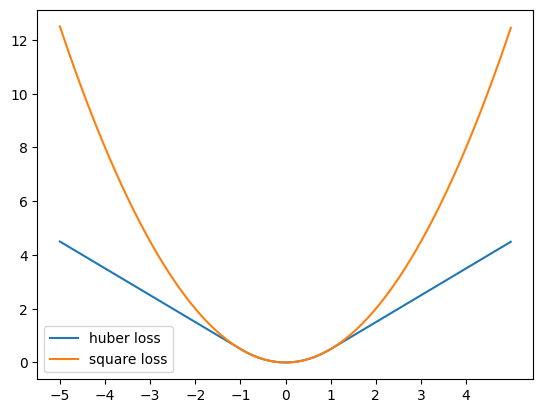

In [4]:
import matplotlib.pyplot as plt
import numpy as np


def huber_loss(deltas, beta=1.):
    if np.abs(deltas) <= beta:
        return 0.5*deltas**2/beta
    else:
        return abs(deltas)-0.5*beta


def mse(deltas):
    return 0.5*deltas**2


deltas = np.arange(-5, 5, 0.01)
plt.plot(deltas, [huber_loss(d) for d in deltas])
plt.plot(deltas, mse(deltas))
plt.xticks(np.arange(-5, 5, step=1))
plt.legend(['huber loss','square loss'])

## 3. DQN实现
### 3.1 experience replay
- 构造batch训练数据
- 采样让整个训练更加稳定

In [5]:
from collections import namedtuple
import random

Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory:
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.memory = []
        self.index = 0

    def push(self, state, action, next_state, reward):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.index] = Transition(state, action, next_state, reward)
        self.index = (self.index+1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### 3.2 DQN network

In [6]:
from torch import nn
import torch
import torch.nn.functional as F
from torch import optim

In [7]:
class DQN(nn.Module):
    def __init__(self, n_states, n_actions) -> None:
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_states, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)

    def forward(self, x):
        return self.fc3(F.relu(self.fc2(F.relu(self.fc1(x)))))

### 3.3 Agent
- tensor shape变化
- shape对齐

In [8]:
class Agent:
    def __init__(self, n_states, n_actions, eta=0.5, gamma=0.99, capacity=10000, batch_size=32) -> None:
        self.n_states = n_states
        self.n_actions = n_actions
        self.eta = eta
        self.gamma = gamma
        self.batch_size = batch_size
        self.memory = ReplayMemory(capacity)
        self.model = DQN(n_states, n_actions)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)

    def _replay(self):
        if len(self.memory) < self.batch_size:
            return
        # list of transition
        batch = self.memory.sample(self.batch_size)
        # Transition, column: len(tuple) == batch_size
        batch = Transition(*zip(*batch))
        # s_t.shape: batch_size * 4
        state_batch = torch.cat(batch.state)
        # a_t.shape: batch_size * 1
        action_batch = torch.cat(batch.action)
        # r_{t+1}.shape: batch_size * 1
        reward_batch = torch.cat(batch.reward)
        # < batch_size
        non_final_next_state_batch = torch.cat(
            [s for s in batch.next_state if s is not None])

        # 构造模型训练用的输入和输出（true）
        # s_t, input

        # pred: Q(s_t, a_t)
        # true: R_{t+1} + \gamma*\max_aQ(s_t, a)

        # 开启 eval 模式
        self.model.eval()

        # pred, batch_size*1
        state_action_values = self.model(
            state_batch).gather(dim=1, index=action_batch)

        # true: R_{t+1} + \gamma*\max_aQ(s_t, a)
        # tuple(map(lambda s: s is not None, batch.next_state)): batch_size 长度的 0/1
        non_final_mask = torch.ByteTensor(
            tuple(map(lambda s: s is not None, batch.next_state)))
        next_state_values = torch.zeros(self.batch_size)
        # Q(s_{t+1}, a)
        next_state_values[non_final_mask] = self.model(
            non_final_next_state_batch).max(dim=1)[0].detach()

        # (batch_size, )
        expected_state_action_values = reward_batch + self.gamma * next_state_values

        # 开启train mode
        self.model.train()

        # expected_state_action_values.unsqueeze(1): (batch_size, ) => (batch_size, 1)
        loss = F.smooth_l1_loss(state_action_values,
                                expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_q_function(self):
        self._replay()

    def memorize(self, state, action, next_state, reward):
        self.memory.push(state, action, next_state, reward)

    # action policy
    # epsilon_greedy
    # double e: explore, exploit
    def choose_action(self, state, episode):
        """
        episode greedy
        """
        eps = 0.5*1/(1+episode)
        if random.random() < eps:
            action = torch.IntTensor([[random.randrange(self.n_actions)]])
        else:
            self.model.eval()
            with torch.no_grad():
                action = self.model(state).max(dim=1)[1].view(1, 1)
        return action


In [9]:
env = gym.make('CartPole-v0', render_mode='rgb_array')
env.reset()
gym.version.VERSION
env.observation_space.shape[0]
env.action_space.n

/Users/tangyun/opt/miniconda3/envs/rl/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


2

- action space

|Num|Action|
|-|-|
|0|Push cart to the left|
|1|Push cart to the righ|

- observation space

|Num|Observation|Min|Max|
|-|-|-|-|
|0|Cart Position|-4.8|4.8|
|1|Cart Velocity|-inf|+inf|
|2|Pole Angle|~-0.418| ~ +0.418|
|3|Pole Angular Velocity|-inf|+inf|


In [10]:
max_episodes = 500
max_steps = 200
complete_episodes = 0
finished_tag = False
frames = []

agent = Agent(env.observation_space.shape[0], env.action_space.n)

for episode in range(max_episodes):
    state, _ = env.reset()
    state = torch.from_numpy(state).type(torch.FloatTensor).unsqueeze(0)
    for step in range(max_steps):
        if finished_tag:
            frames.append(env.render())
        # IntTensor of 1*1
        action = agent.choose_action(state, episode)

        next_state, reward, done, _, _ = env.step(action.item())

        if done:
            next_state = None
            if step < 150:
                reward = torch.FloatTensor([-1.])
                complete_episodes = 0
            else:
                reward = torch.FloatTensor([1.])
                complete_episodes += 1
        else:
            reward = torch.FloatTensor([0])
            # (4,) -> (1,4)
            next_state = torch.from_numpy(next_state).unsqueeze(0)
        agent.memorize(state, action, next_state, reward)
        agent.update_q_function()
        state = next_state
        if done:
            print(f"episode:{episode}, step:{step}")
            break
    if finished_tag:
        break
    if complete_episodes > 5:
        print("complete_episodes>5")
        finished_tag = True

/Users/tangyun/opt/miniconda3/envs/rl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/var/folders/xk/n87yv7vd6qj6v2nsxdv9q8d80000gn/T/ipykernel_98319/4287980315.py:48: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/IndexingUtils.h:28.)
  next_state_values[non_final_mask] = self.model(


episode:0, step:15
episode:1, step:9
episode:2, step:9
episode:3, step:8
episode:4, step:41
episode:5, step:26
episode:6, step:37
episode:7, step:17
episode:8, step:25
episode:9, step:36
episode:10, step:22
episode:11, step:29
episode:12, step:26
episode:13, step:30
episode:14, step:68
episode:15, step:39
episode:16, step:33
episode:17, step:77
episode:18, step:56
episode:20, step:122
episode:21, step:73
episode:22, step:105
episode:23, step:104
episode:24, step:128
episode:25, step:95
episode:26, step:119
episode:27, step:93
episode:28, step:132
episode:33, step:178
episode:34, step:120
episode:35, step:135
episode:36, step:165
episode:37, step:121
episode:38, step:117
episode:39, step:130
episode:40, step:196
episode:41, step:158
episode:42, step:135
episode:45, step:195
episode:50, step:128
episode:51, step:116
episode:54, step:178
episode:57, step:11
episode:58, step:12
episode:59, step:9
episode:60, step:8
episode:61, step:8
episode:62, step:9
episode:63, step:9
episode:64, step:1

In [11]:
len(frames)
frames[0].shape

IndexError: list index out of range

## 3. rendering&animation


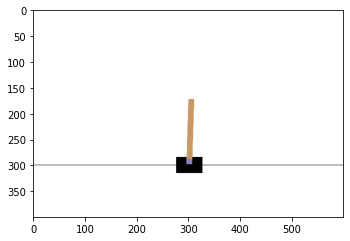

: 

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML


# def display_frames_to_video(frames, name):
plt.figure(figsize=(frames[0].shape[0]/72, frames[0].shape[1]/72), dpi=72)
patch = plt.imshow(frames[0])

def animate(i):
    patch.set_data(frames[i])
anim = animation.FuncAnimation(
    plt.gcf(), animate, frames=range(len(frames)), interval=50)
anim.save(f"xx.gif")
# HTML(anim.to_jshtml())

# display_frames_to_video(frames=frames, name="xx")